<a href="https://www.kaggle.com/code/sarahserafini/s3e18-with-tensorflow-neural-network?scriptVersionId=136325534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Explore Multi-Label Classification with an Enzyme Substrate Dataset
 
"The dataset for this competition (both train and test) was generated from a deep learning model trained on a portion of the Multi-label Classification of enzyme substrates. This dataset only uses a subset of features from the original (the features that had the most signal). Feature distributions are close to, but not exactly the same, as the original."

The **aim** is to preditc the featues EC1 and EC2

**Evaluation**: Submissions are evaluated on area under the ROC curve between the predicted probability and the ground truth for each target, and the final score is the average of the individual AUCs of each predicted column.

**Sources**:

- [Kaggle challenge](https://www.kaggle.com/competitions/playground-series-s3e18/overview/description)
- [Original Dataset](https://www.kaggle.com/datasets/gopalns/ec-mixed-class)

# Outline
- [ 1 - Read Data ](#1) 
- [ 2 - EDA - Exploratory Data Analysis](#2)
- [ 3 - Preprocessing Data Before Modeling](#3)
- [ 4 - Model Training](#4)
- [ 5 - Neural Network](#5)
- [ 6 - Model Comparison](#6)
- [ 7 - Challenge Submission](#7)

In [105]:
# importing standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, LearningCurveDisplay, ShuffleSplit

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [106]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'axes.titlesize': 16,
    'figure.figsize': (12, 4),
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('colorblind'), 
              rc=theme_parameters)

<a name="1"></a>
# Read Data

In [107]:
read_from_kaggle = True

In [108]:
if read_from_kaggle:
    
    train_data = pd.read_csv('/kaggle/input/playground-series-s3e18/train.csv',
                       index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv',
                       index_col=0)
    
    
else:

    train_data = pd.read_csv("./../../data/enzyme_substrate_train.csv",
                            index_col=0)
    test_data = pd.read_csv("./../../data/enzyme_substrate_test.csv",
                            index_col=0)

In [109]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 0 to 14837
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            14838 non-null  float64
 1   Chi1               14838 non-null  float64
 2   Chi1n              14838 non-null  float64
 3   Chi1v              14838 non-null  float64
 4   Chi2n              14838 non-null  float64
 5   Chi2v              14838 non-null  float64
 6   Chi3v              14838 non-null  float64
 7   Chi4n              14838 non-null  float64
 8   EState_VSA1        14838 non-null  float64
 9   EState_VSA2        14838 non-null  float64
 10  ExactMolWt         14838 non-null  float64
 11  FpDensityMorgan1   14838 non-null  float64
 12  FpDensityMorgan2   14838 non-null  float64
 13  FpDensityMorgan3   14838 non-null  float64
 14  HallKierAlpha      14838 non-null  float64
 15  HeavyAtomMolWt     14838 non-null  float64
 16  Kappa3             148

In [110]:
train_data.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
id,,,,,,,,,,,,,,,,,,,,,
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [111]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9893 entries, 14838 to 24730
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            9893 non-null   float64
 1   Chi1               9893 non-null   float64
 2   Chi1n              9893 non-null   float64
 3   Chi1v              9893 non-null   float64
 4   Chi2n              9893 non-null   float64
 5   Chi2v              9893 non-null   float64
 6   Chi3v              9893 non-null   float64
 7   Chi4n              9893 non-null   float64
 8   EState_VSA1        9893 non-null   float64
 9   EState_VSA2        9893 non-null   float64
 10  ExactMolWt         9893 non-null   float64
 11  FpDensityMorgan1   9893 non-null   float64
 12  FpDensityMorgan2   9893 non-null   float64
 13  FpDensityMorgan3   9893 non-null   float64
 14  HallKierAlpha      9893 non-null   float64
 15  HeavyAtomMolWt     9893 non-null   float64
 16  Kappa3             

In [112]:
test_data.head()

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
id,,,,,,,,,,,,,,,,,,,,,
14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,0.000000,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,29.783175,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,6.420822,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,47.360206,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


<a name="2"></a>
# EDA - Exploratory Data Analysis

## Numeric Feature Distribution Train vs Test Data KDEs

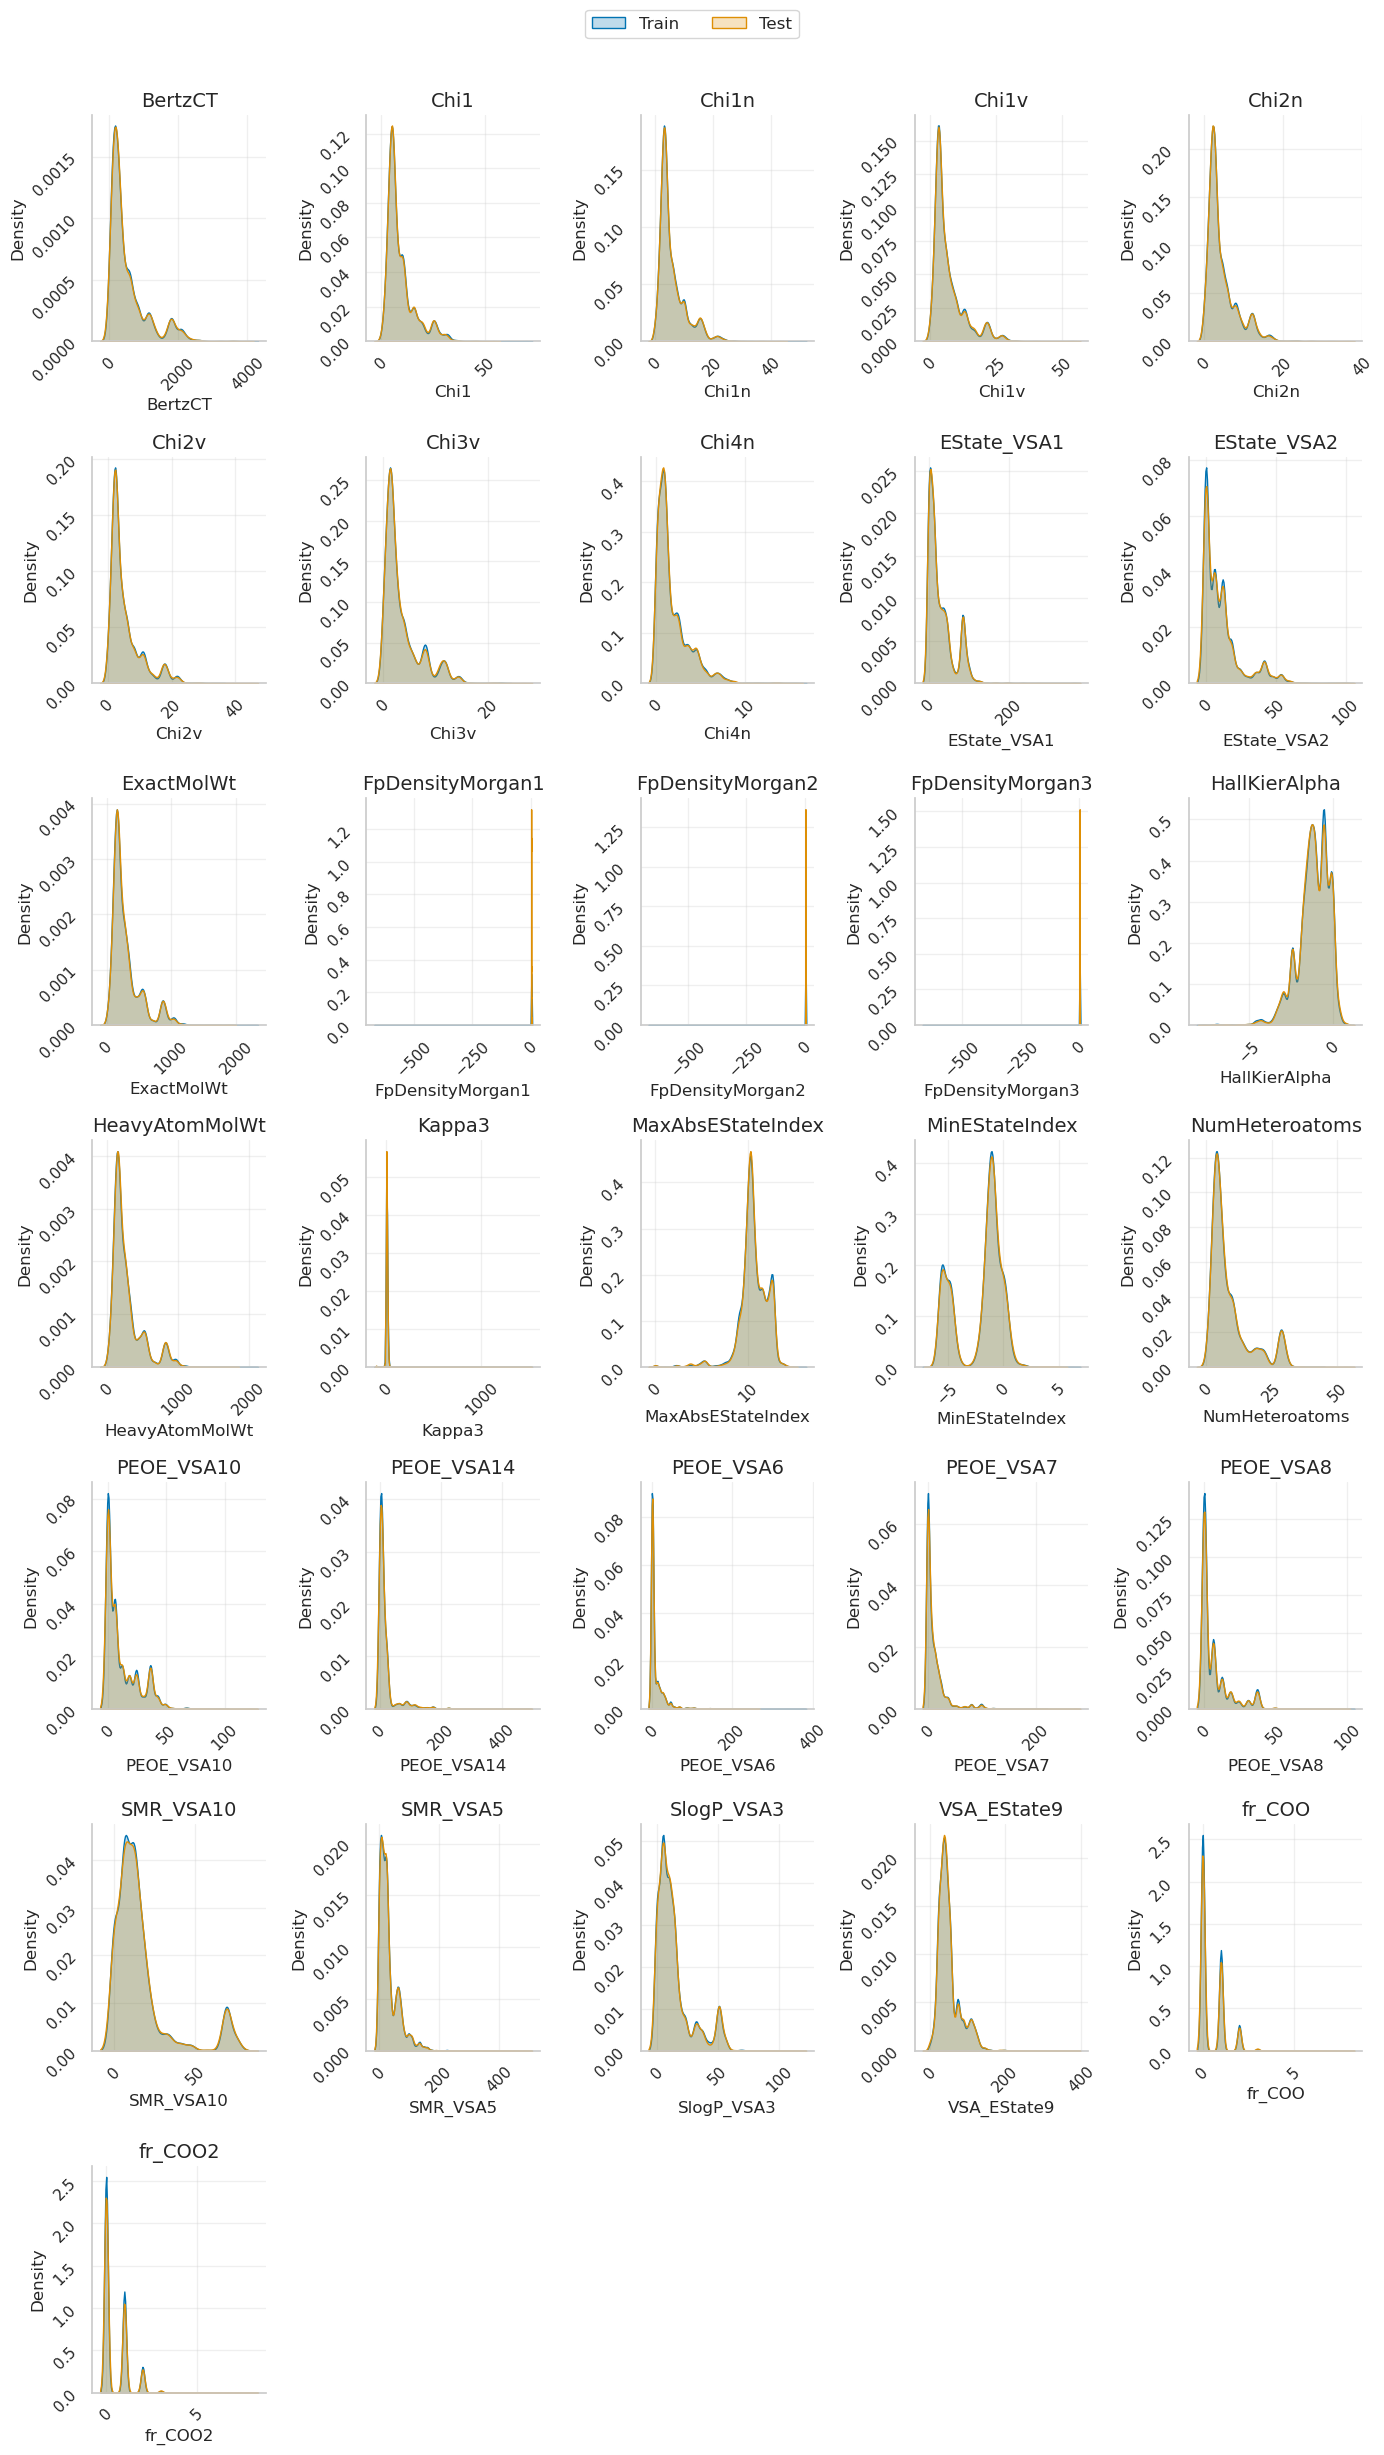

In [113]:
figure, ax = plt.subplots(7, 5, figsize=(14, 24))
ax = ax.flatten()

# create a list to exclude categorical features and the label
exclude_columns = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

for index, col_name in enumerate([col for col in train_data.columns if col not in exclude_columns]):
    
    sns.kdeplot(data=train_data[col_name],
                label='Train',
                fill=True,
                ax=ax[index])
    
    sns.kdeplot(data=test_data[col_name],
                label='Test',
                fill=True,
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplots
figure.delaxes(ax[-4])
figure.delaxes(ax[-3])
figure.delaxes(ax[-2])
figure.delaxes(ax[-1])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

plt.tight_layout()
plt.show()

## Label Bar Plot

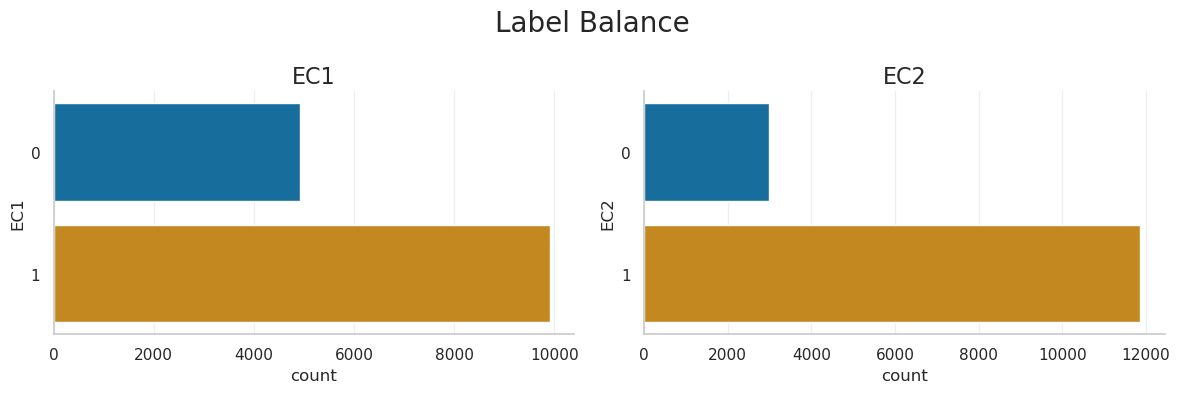

In [114]:
figure, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.flatten()

sns.countplot(data=train_data, 
              y='EC1',
              ax=ax[0])

sns.countplot(data=train_data, 
              y='EC2',
              ax=ax[1])

ax[0].set_title('EC1')
ax[1].set_title('EC2')

plt.suptitle('Label Balance', fontsize=20) 

plt.tight_layout()
plt.show()

## Pairplots

In [115]:
train_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


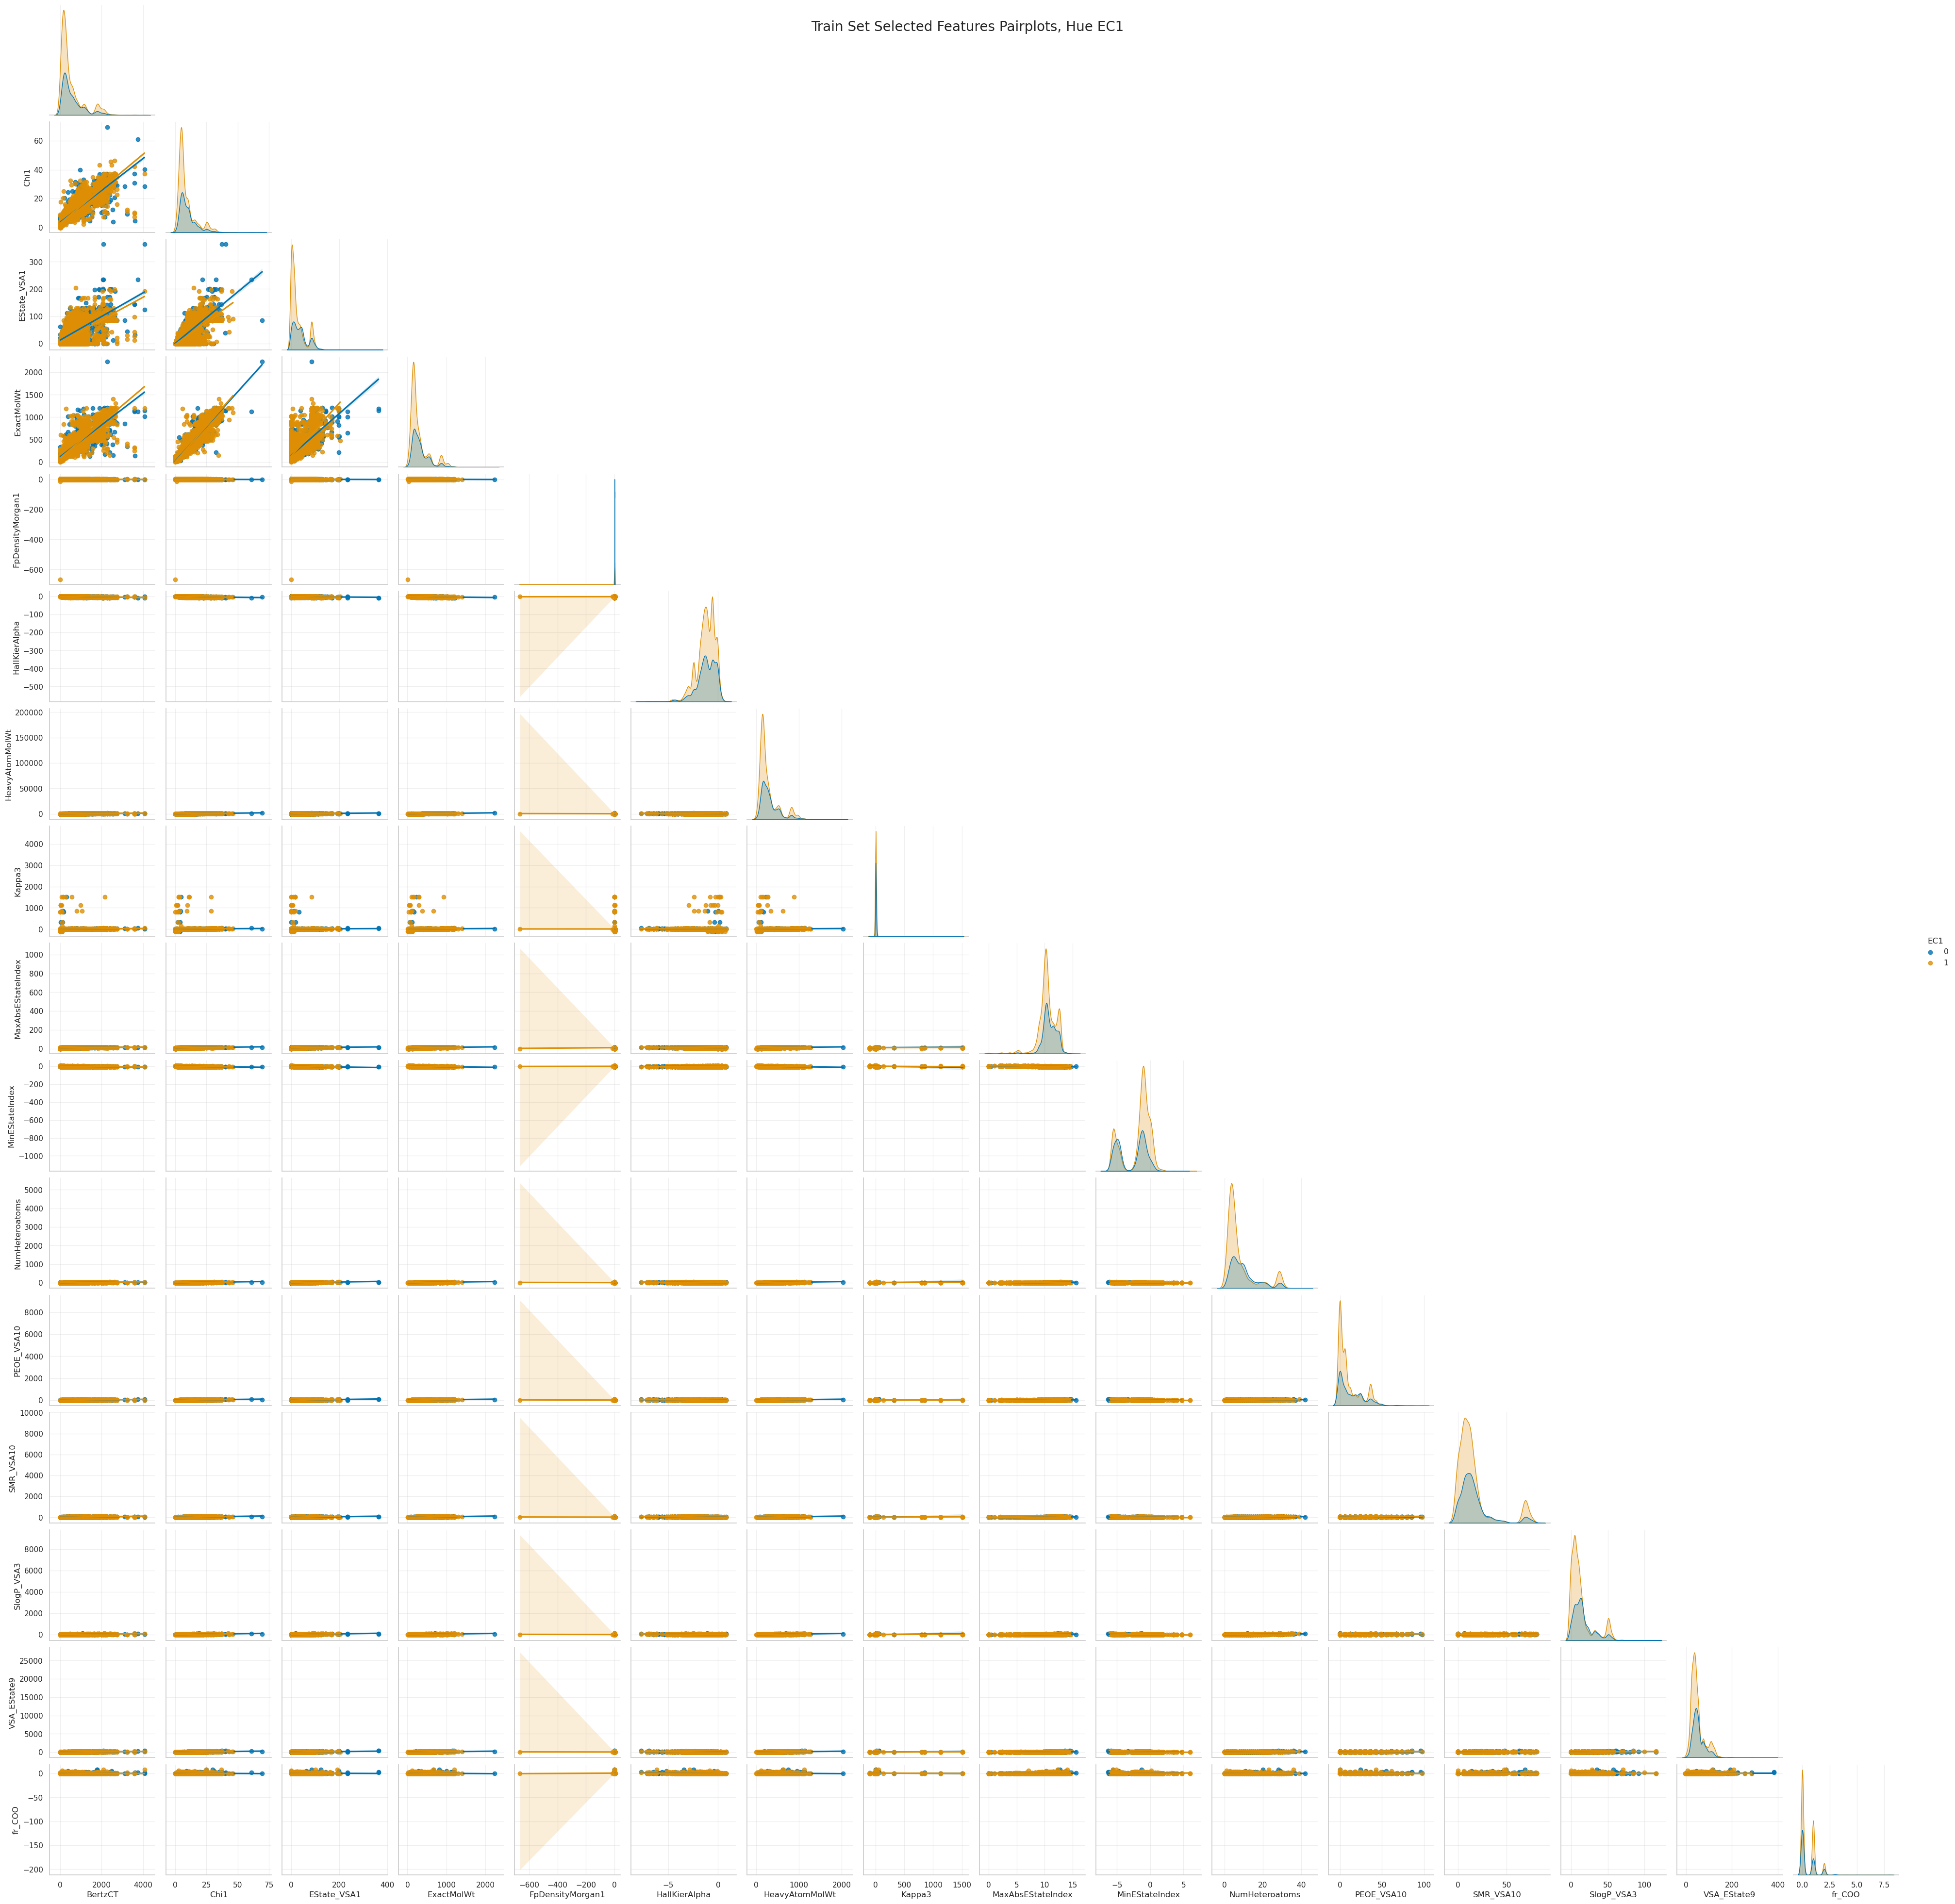

In [116]:
sns.pairplot(train_data[['BertzCT', 'Chi1', 
       'EState_VSA1', 'ExactMolWt', 'FpDensityMorgan1', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 
     'SMR_VSA10', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'EC1']],
             hue='EC1',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Train Set Selected Features Pairplots, Hue EC1', 
             fontsize=20)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


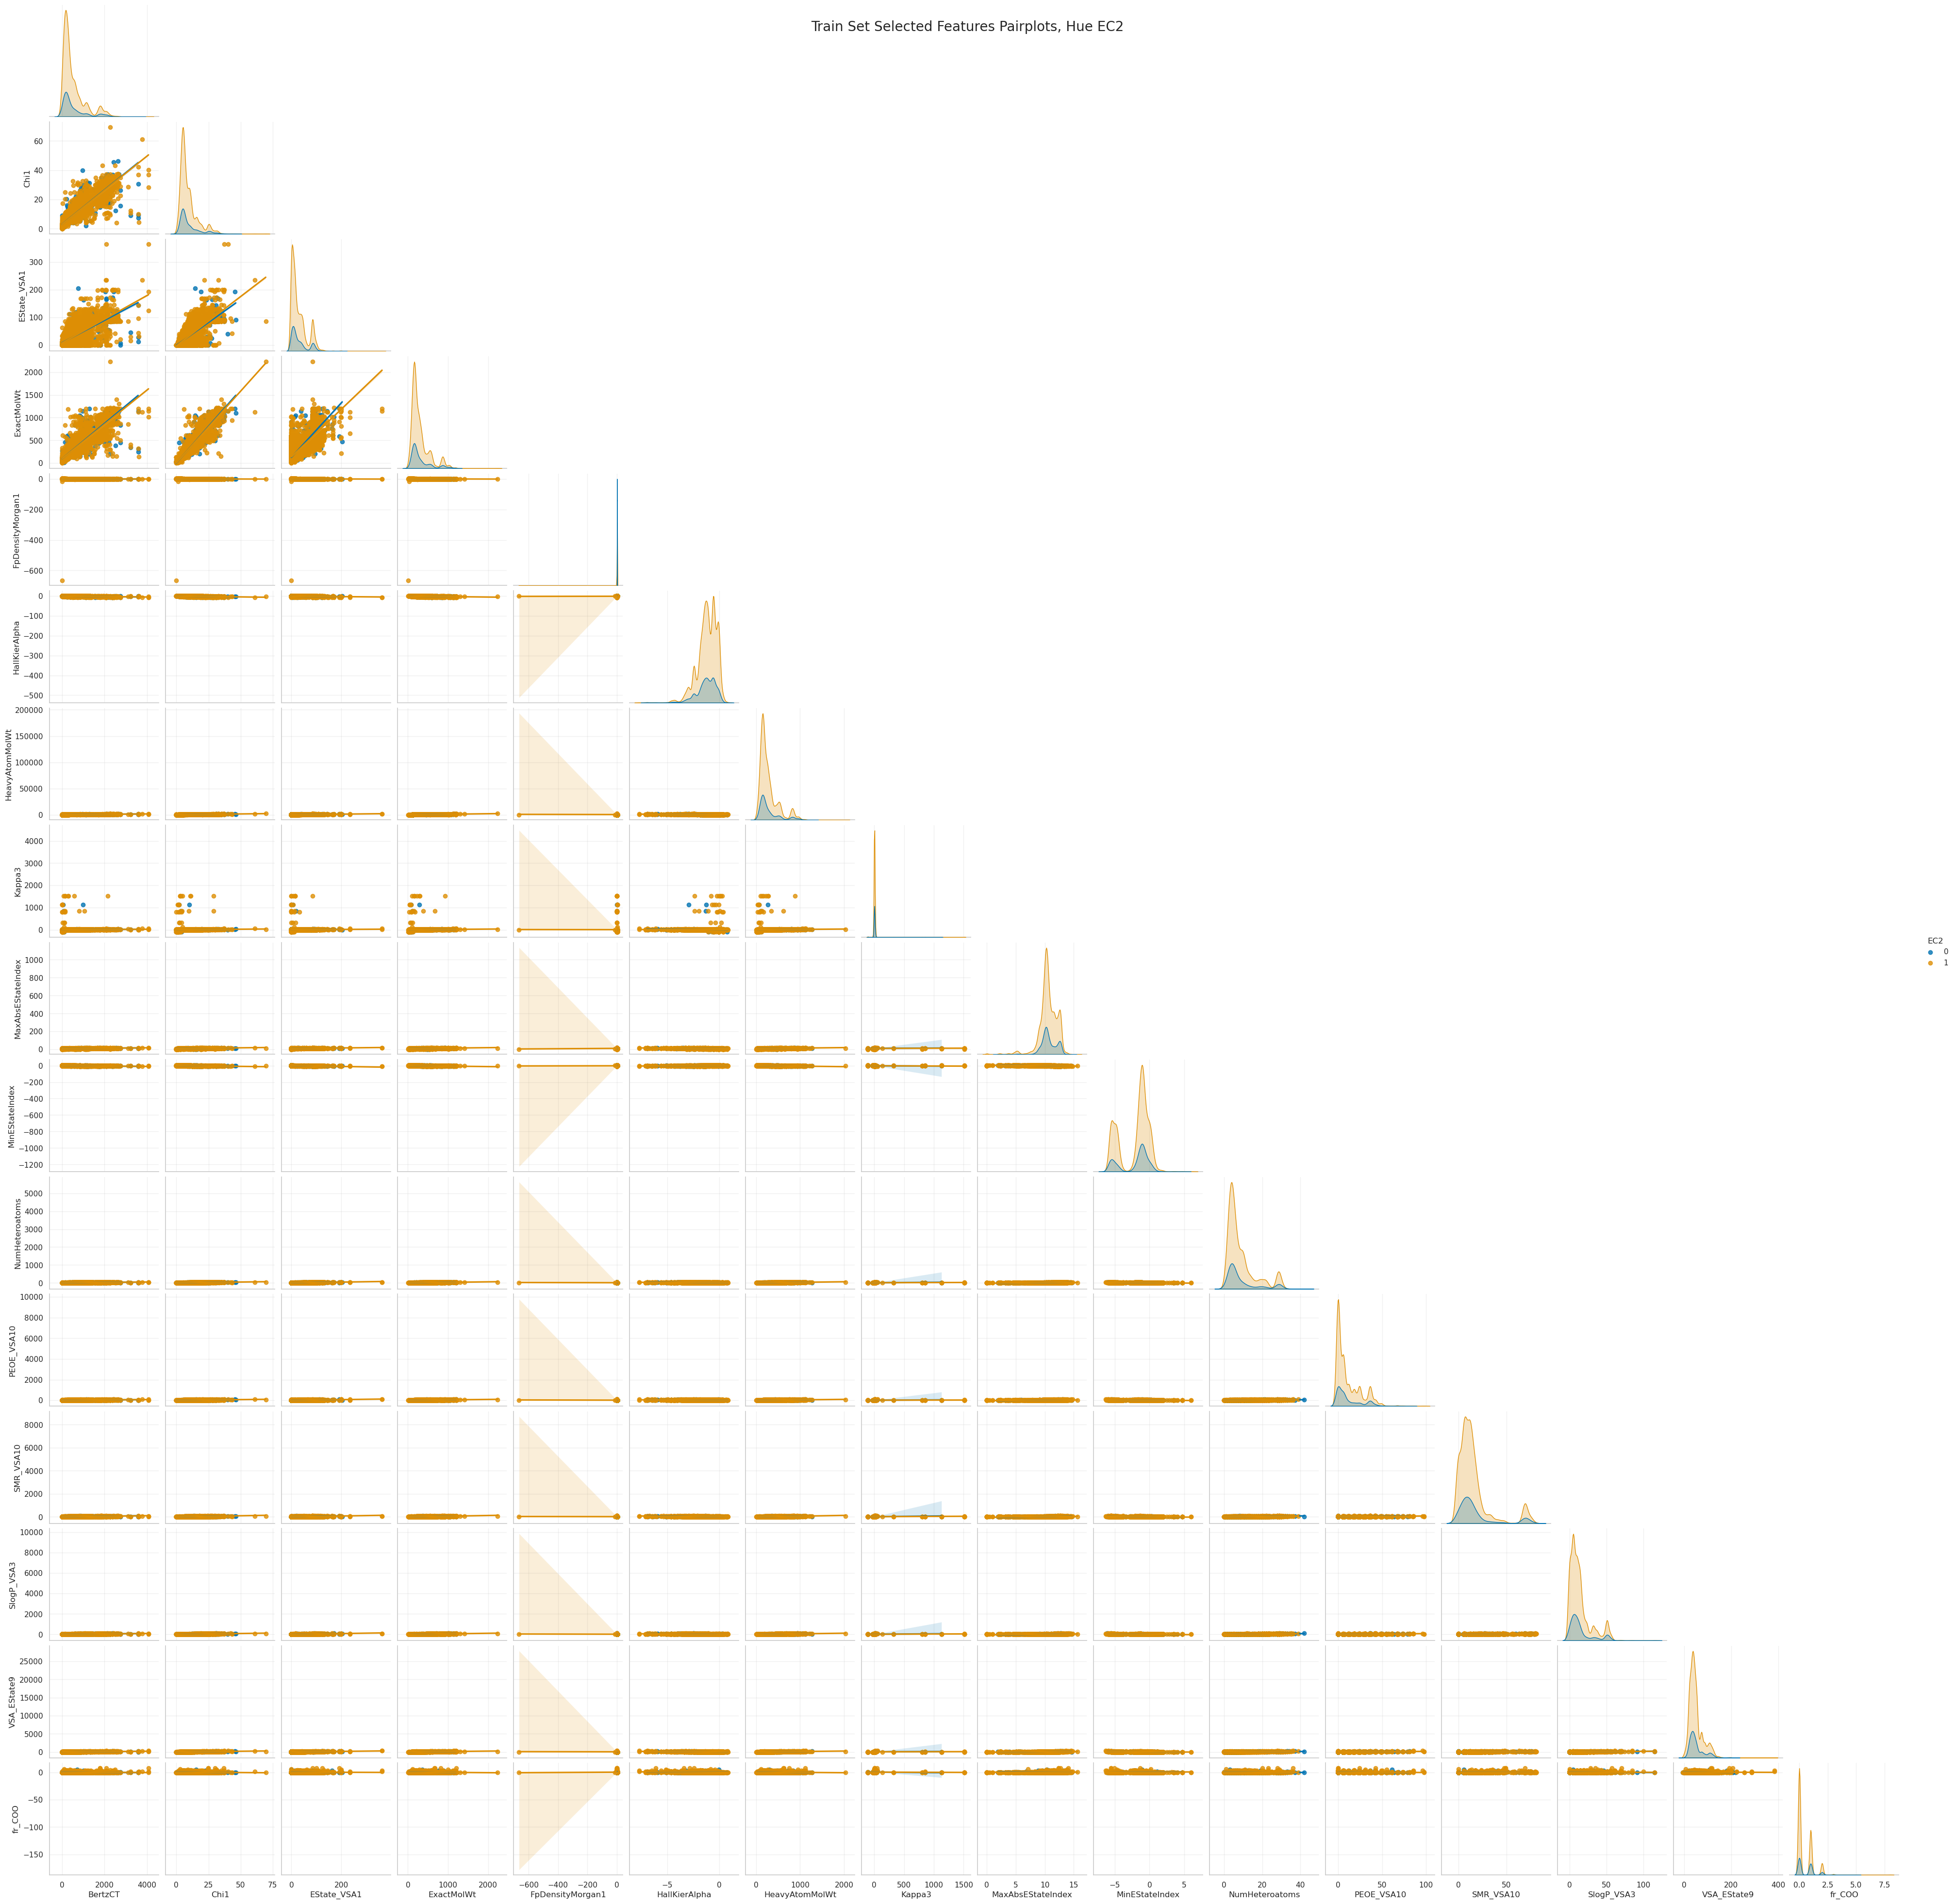

In [117]:
sns.pairplot(train_data[['BertzCT', 'Chi1', 
       'EState_VSA1', 'ExactMolWt', 'FpDensityMorgan1', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 
     'SMR_VSA10', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'EC2']],
             hue='EC2',
             kind="reg",
             diag_kind='kde',
             corner=True)

plt.suptitle('Train Set Selected Features Pairplots, Hue EC2', 
             fontsize=20)

plt.show()

## Spearman Correlation

In [118]:
train_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'],
      dtype='object')

In [119]:
# Define a list of columns to use to compute the correlation
corr_columns = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2']

In [120]:
# Generate correlation matrix train set
correlation_train = train_data[corr_columns].corr(method='spearman')

# Generate a mask for the upper triangle
correlation_mask_train = np.triu(np.ones_like(correlation_train, dtype=bool))

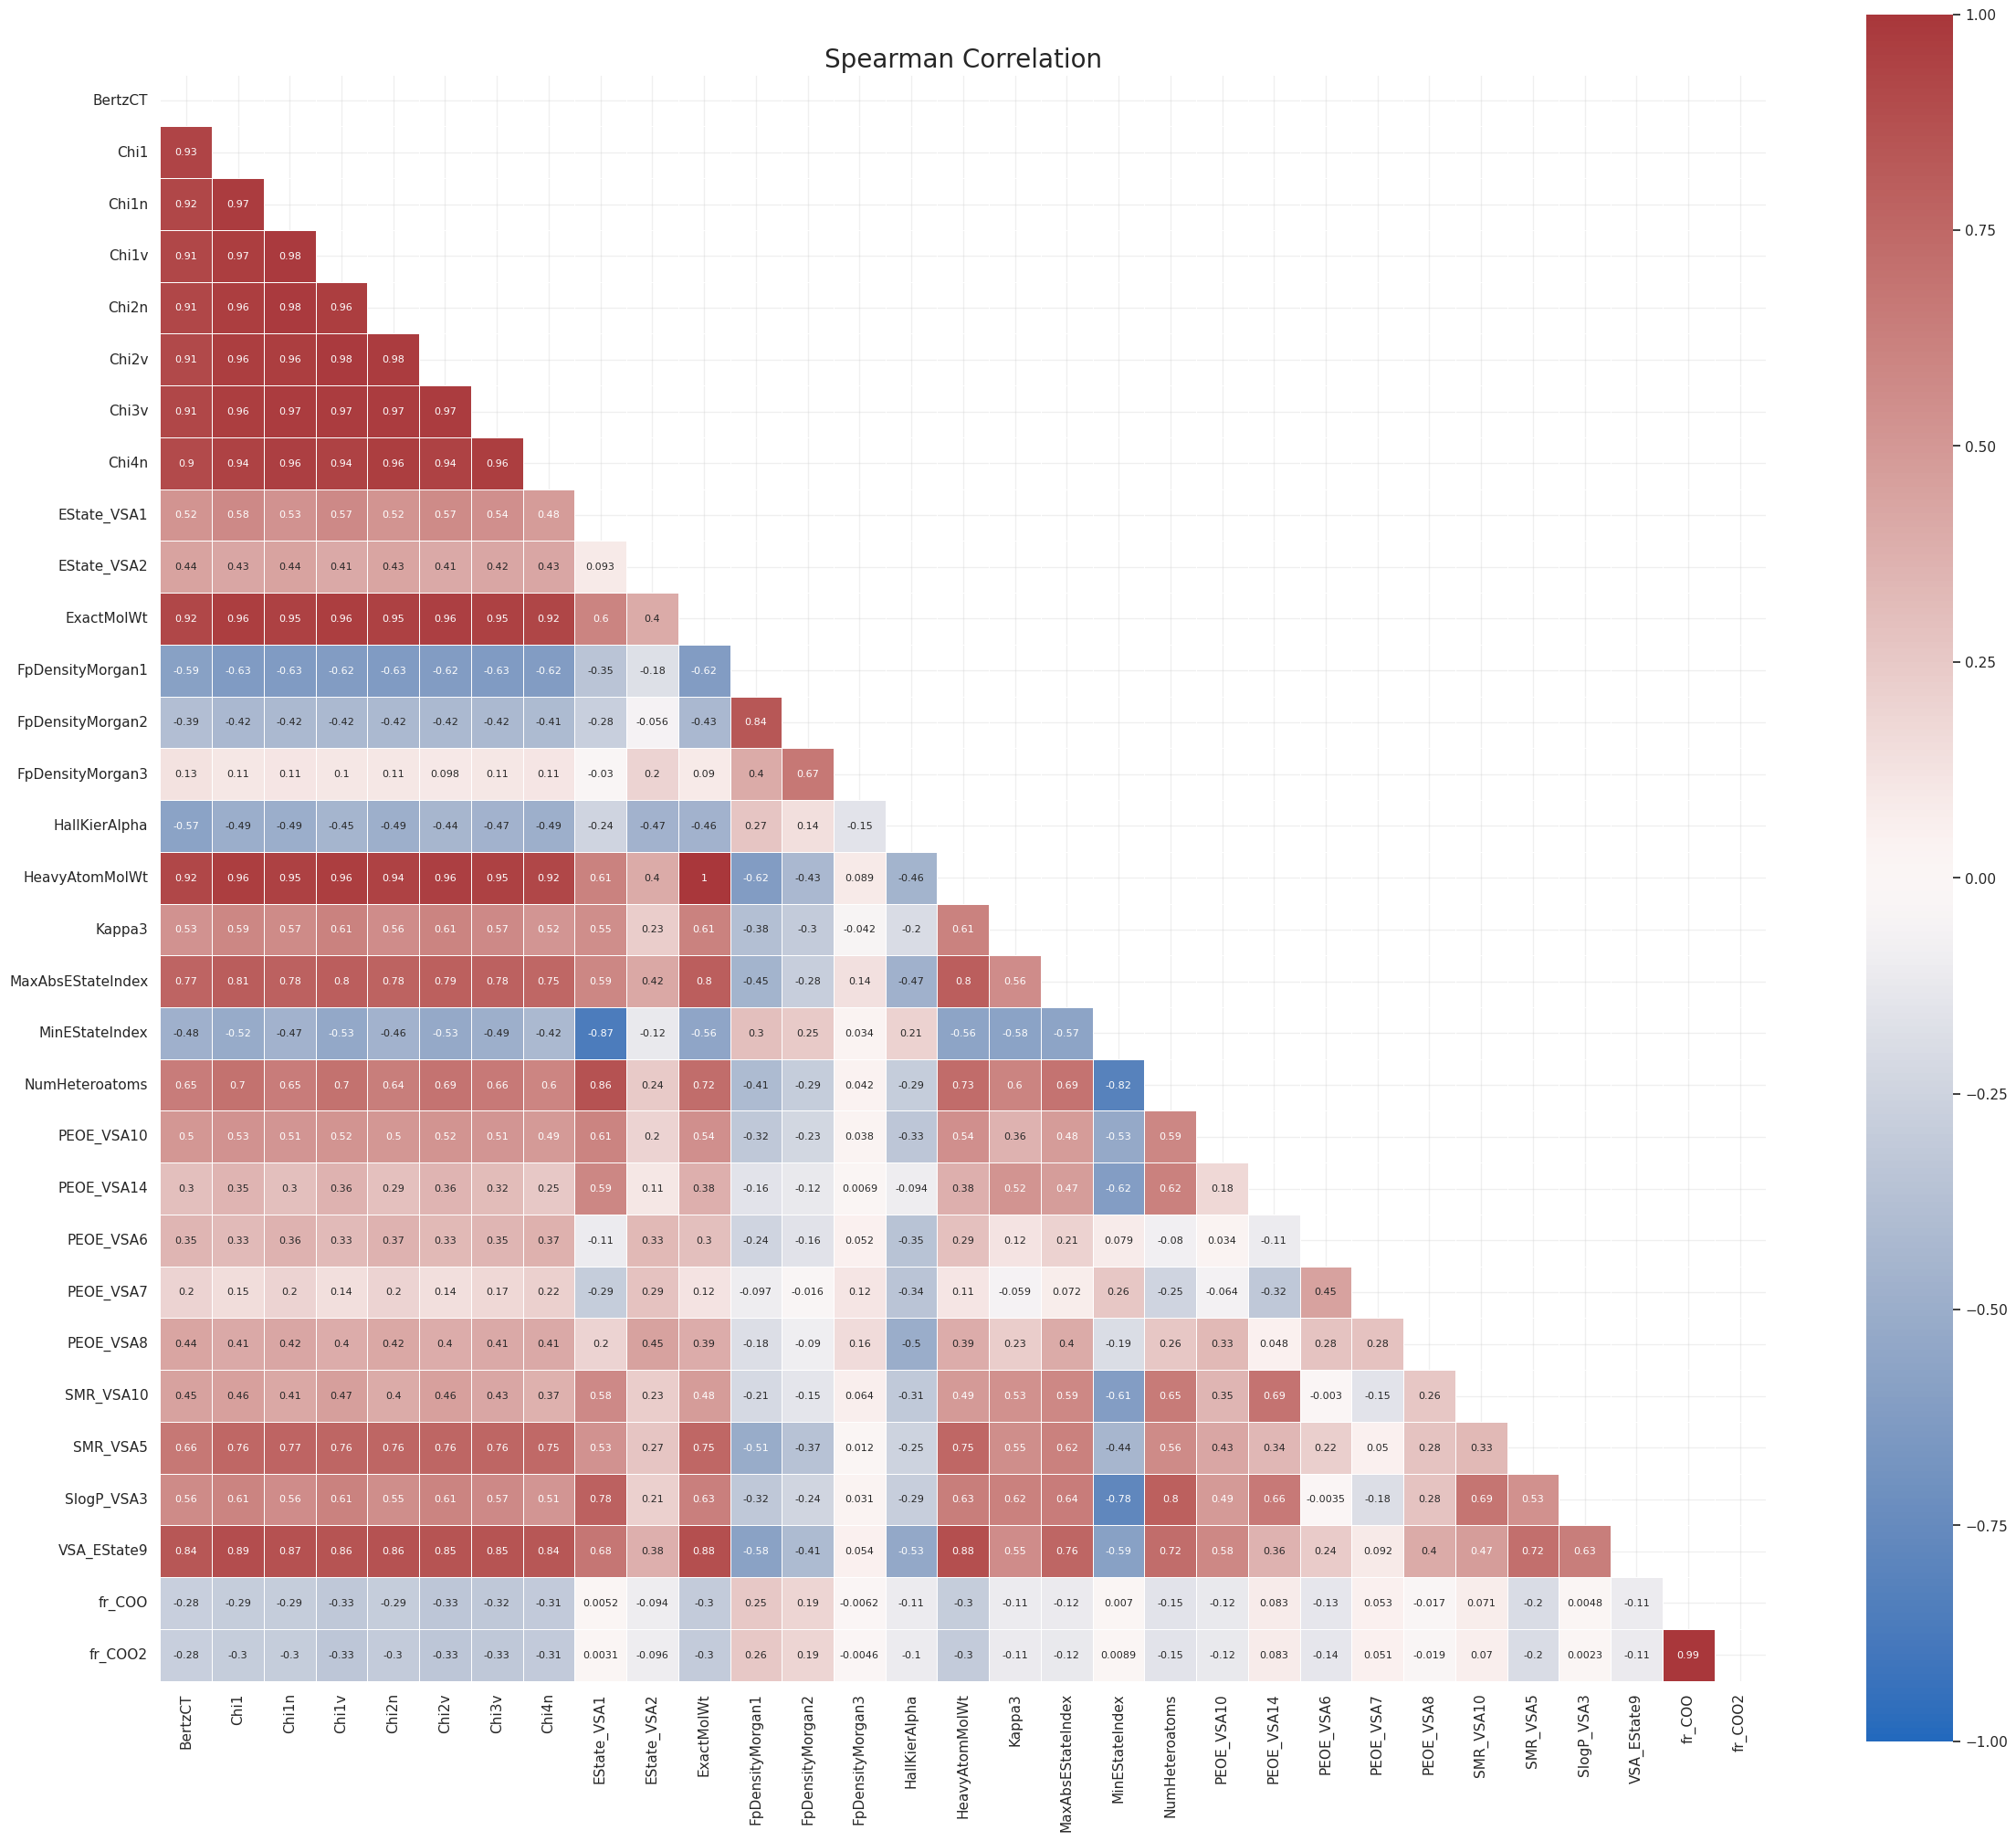

In [121]:
plt.figure(figsize=(24, 24))  # Adjust the figure size as per your preference

sns.heatmap(correlation_train,
            mask=correlation_mask_train,
            cmap='vlag',
            vmax=1.0,
            vmin=-1.0,
            center=0,
            square=True,
            linewidths=0.5,
            annot=True,
            annot_kws={'fontsize': 8},
            cbar_kws={"shrink": 0.8, 'orientation': 'vertical'})

plt.title('Spearman Correlation', fontsize=20)

plt.tight_layout()
plt.show()

## Conclusions

- We see that the fail categories in the features and in the label are quite unbalanced, but not to heavily.
- Some features show an extrimely similar behaviour (e.g FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3)

### Whats nexts
- Scaling and normalizing data before modeling end building a neural network

<a name="3"></a>
# Data Preprocessing

In [122]:
train_data.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'],
      dtype='object')

## Defining features and Labels

In [123]:
numerical_features = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2']

labels = ['EC1', 'EC2']

## Scaling and Normalizing Numerical Features

In [124]:
# Initialize Scaler
scaler = MinMaxScaler()

# Fit and transform the train data using the pipeline
transformed_train_data = pd.DataFrame(scaler.fit_transform(train_data[numerical_features]))

# Scaling removed column names - put them back
transformed_train_data.columns = numerical_features

# Reset index
transformed_train_data.index = train_data.index

# Log transformation on train data
transformed_train_data[numerical_features] = np.log1p(transformed_train_data[numerical_features])

# Transform test data
transformed_test_data = pd.DataFrame(scaler.transform(test_data[numerical_features]))

# Scaling removed column names - put them back
transformed_test_data.columns = numerical_features

# Reset index
transformed_test_data.index = test_data.index

# Log transformation on test data
transformed_test_data[numerical_features] = np.log1p(transformed_test_data[numerical_features])

## Splitting Data Between Train and Test Set

In [125]:
# Defining a seed
seed = 108

In [126]:
# Define X and y for the training set
X = transformed_train_data
y = train_data[labels]

# Splitting train dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

<a name="4"></a>
# Model Training

In [127]:
# Define metric(s) to compare the models
metrics = ['AUC_ROC']

# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## XGBClassifier

In [128]:
# define XGBoost hyperparams dict
hyperparams_xgbc = {
    'max_depth' : 5,
    'learning_rate' : 0.01,
    'n_estimators' : 500
}

In [129]:
# Instantiate a XGBClassifier model
model_xgbc = XGBClassifier(**hyperparams_xgbc)

# Fit model to the train set
model_xgbc.fit(X_train, y_train)

# Predict y_pred
y_pred_xgbc = model_xgbc.predict(X_test)

# Compute AUC_ROC metric
auc_roc_xgbc = roc_auc_score(y_test, y_pred_xgbc)

print('AUC_ROC: {}'.format(auc_roc_xgbc))

AUC_ROC: 0.5626334694830928


In [130]:
# Update 'performance' DataFrame
performance.loc['XGBClassifier'] = [auc_roc_xgbc]

<a name="5"></a>
# Neural Network

Building a simple neural network with TenforFlow and Keras. Hidden layers with ReLU as activation funciton and the last layer with a linear activation function (instead of a sigmoid, to increase numerical accuracy of prefictions. The probabilities will be calculated later with BinaryCrossentropy function, setting from_logits=True while compiling the model.

In [131]:
# Set random seed
tf.random.set_seed(108)

# Define Neural Network Architecture
model_tf = Sequential(
    [               
        Dense(70, activation='relu', name='L1'),
        Dense(50, activation='relu', name='L2'),
        Dense(30, activation='relu', name='L3'),
        Dense(20, activation='relu', name='L4'),
        Dense(15, activation='relu', name='L5'),
        Dense(7, activation='relu', name='L6'),
        Dense(2, activation='linear', name='L7'),
    ]
)

In [132]:
%%time

model_tf.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model_tf.fit(
    X_train, 
    y_train,
    epochs=10
)

Epoch 1/10
311/311 [==============================] - 2s 2ms/step - loss: 0.6196
Epoch 2/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5560
Epoch 3/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5436
Epoch 4/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5420
Epoch 5/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5402
Epoch 6/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5399
Epoch 7/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5393
Epoch 8/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5388
Epoch 9/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5387
Epoch 10/10
311/311 [==============================] - 1s 2ms/step - loss: 0.5392
CPU times: user 10.3 s, sys: 649 ms, total: 10.9 s
Wall time: 11.8 s


In [133]:
# Generate Prediction
y_pred_tf = model_tf.predict(X_test)

roc_auc_tf = roc_auc_score(y_test, y_pred_tf)
print('AUC_ROC: {}'.format(roc_auc_tf))

154/154 [==============================] - 0s 1ms/step
AUC_ROC: 0.6334016591410374


In [134]:
# Update 'performance' DataFrame
performance.loc['TF Neural Network'] = [roc_auc_tf]

<a name="6"></a>
# Model Comparison

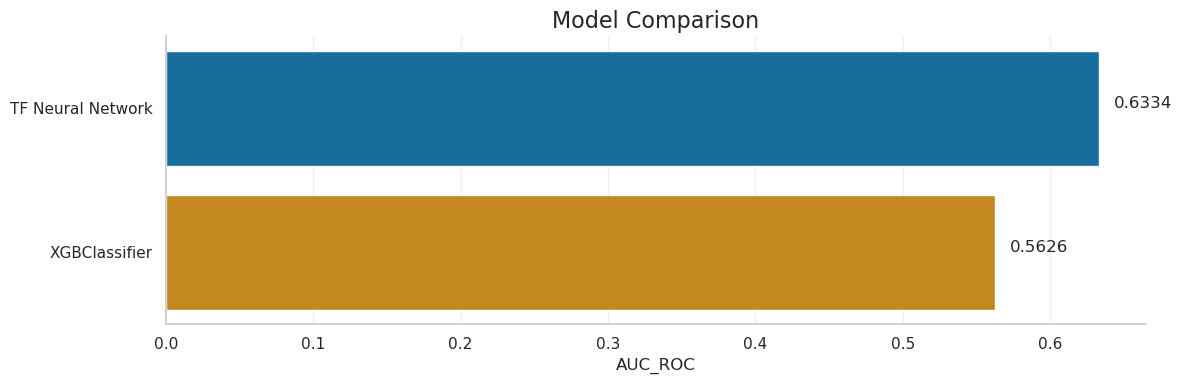

In [135]:
# Sort dataframe by the metric
performance.sort_values('AUC_ROC', ascending=False, inplace=True)

# Plot model metrics
ax = sns.barplot(data=performance, 
                 x='AUC_ROC', 
                 y=performance.index.tolist())

# Add data labels to the bars
for i, v in enumerate(performance['AUC_ROC']):
    ax.text(v + 0.01, i, str(round(v, 4)))

ax.set_title('Model Comparison')

plt.tight_layout()
plt.show()

<a name="7"></a>
# Challenge Submission

In [136]:
# Generate predictions with test set with the besst performing model (based on ROC_AUC)
submission_predictions = model_tf.predict(transformed_test_data)

310/310 [==============================] - 0s 1ms/step


In [137]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data.index, 'EC1': submission_predictions[:, 0], 'EC2': submission_predictions[:, 1]})

In [138]:
submission.head()

,id,EC1,EC2
0,14838,-0.348832,1.564070
1,14839,1.439254,1.447941
2,14840,1.358423,1.317101
3,14841,1.129870,1.867659
4,14842,1.083095,1.128819


In [139]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)